## D-Wave Error Correction: Forward and Reverse Annealing Together!?!?

In [73]:
# The Stanard Hodgepodge of Imports for Python
import qutip as qt
import qutip.states as qts
import qutip.operators as qto
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import seaborn as sns
from functools import reduce

sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (nqubit_1pauli, nqubit_2pauli, loadAandB, dict_to_qutip,
                       make_numeric_schedule, get_numeric_H, time_interpolation)

### We will illustrate the process using a 3 qubit triangular problem.

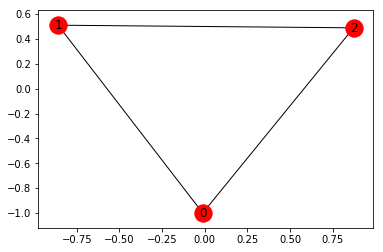

In [6]:
# First, let's create a sample 3 qubit Hamiltonian no h bias and all Ferromagnetic coupling
H = {(0, 0): 0, (1, 1): 0, (2, 2): 0, (0, 1): 1, (1, 2): 1, (0, 2): 1}
systot = DictRep(H = H, qpu = 'dwave', vartype = 'ising', encoding = 'logical')
graph = systot.visualize_graph()

While this is the Logical Hamiltonian we would LIKE to solve, we are interested in breaking it up into subsystems we'll call A and B so that we can forward/ reverse anneal them in tandem. 

In [3]:
# This is H, minus the coupling that connects qubit 1 to qubit 2
HA = {(0, 0): 0, (1, 1): 0, (2, 2): 0, (0, 1): 1, (0, 2): 1, (1, 2): 0}
sysA = DictRep(HA, 'dwave', 'ising', 'logical')
# this only includes the coupling between qubits 1 and 2
HB = {(0, 0): 0, (1, 1): 0, (2, 2): 0, (0, 1): 0, (0, 2): 0, (1, 2): 1}
sysB = DictRep(HB, 'dwave', 'ising', 'logical')

Now, we will create three anneal schedules. The first will be used to perform a forward anneal on the total system. The other two will be to perform a forward/ reverse anneal on system A/B. 

In [19]:
T = .1
# total system anneal schedule
systot_schedule = make_numeric_schedule(.1, **{'direction': 'forward', 'ta': T})
systot_times, systot_svals = systot_schedule[0], systot_schedule[1]
# system A forward anneal (this is redundant but used to be pedantically clear)
sysA_schedule = make_numeric_schedule(.1, **{'direction': 'forward', 'ta': T})
sysA_times, sysA_svals = sysA_schedule[0], sysA_schedule[1]
# system B reverse anneal schedule
sysB_schedule = make_numeric_schedule(.1, **{'direction': 'reverse', 'ta': T/2, 'sa': 0.5, 'tq': T/2})
sysB_times, sysB_svals = sysB_schedule[0], sysB_schedule[1]

As the last pre-processing step, we will create the three separate numerical and list-based Hamiltonians to actually run the QuTip simulations on each three of the systems.

In [20]:
processor_data = loadAandB()
# Crearing the Hamiltonian for the ENTIRE system
systot_ABfuncs = time_interpolation(systot_schedule, processor_data)
systot_numericH = get_numeric_H(systot)
systot_A = systot_ABfuncs['A(t)']
systot_B = systot_ABfuncs['B(t)']
systot_HX = systot_numericH['HX']
systot_HZ = systot_numericH['HZ']
# "Analytic" or function H(t)
systot_H = lambda t : systot_A(t)*systot_HX + systot_B(t)*systot_HZ
# Define list_H for QuTiP
systot_listH = [[systot_HX, systot_A], [systot_HZ, systot_B]]

In [37]:
# Create the Hamiltonian for system A
sysA_ABfuncs = time_interpolation(sysA_schedule, processor_data)
sysA_numericH = get_numeric_H(sysA)
sysA_A = sysA_ABfuncs['A(t)']
sysA_B = sysA_ABfuncs['B(t)']
sysA_HX = sysA_numericH['HX']
sysA_HZ = sysA_numericH['HZ']
# "Analytic" or function H(t)
sysA_H = lambda t : sysA_A(t)*sysA_HX + sysA_B(t)*sysA_HZ
# Define list_H for QuTiP
sysA_listH = [[sysA_HX, sysA_A], [sysA_HZ, sysA_B]]

In [31]:
# Create the Hamiltonian for system B
sysB_ABfuncs = time_interpolation(sysB_schedule, processor_data)
sysB_numericH = get_numeric_H(sysB)
sysB_A = sysB_ABfuncs['A(t)']
sysB_B = sysB_ABfuncs['B(t)']
sysB_HX = sysB_numericH['HX']
sysB_HZ = sysB_numericH['HZ']
# "Analytic" or function H(t)
sysB_H = lambda t : sysB_A(t)*sysB_HX + sysB_B(t)*sysB_HZ
# Define list_H for QuTiP
sysB_listH = [[sysB_HX, sysB_A], [sysB_HZ, sysB_B]]

In [52]:
# Combine system A and system B Hamitlonian's into a single Hamiltonian and compare to sysT and 
# some time in the middle of the anneal and at the end
sysAB_listH = [[sysA_HX, sysA_A], [sysA_HZ, sysA_B], [sysB_HX, sysB_A], [sysB_HZ, sysB_B]]
sysAB_H = lambda t: sysA_H(t) + sysB_H(t)
sysAB_H(T/2)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 9.73732105  1.34575661  1.34575661  0.          1.34575661  0.
   0.          0.        ]
 [ 1.34575661 -3.24651505  0.          1.34575661  0.          1.34575661
   0.          0.        ]
 [ 1.34575661  0.         -3.24651505  1.34575661  0.          0.
   1.34575661  0.        ]
 [ 0.          1.34575661  1.34575661 -3.24429095  0.          0.
   0.          1.34575661]
 [ 1.34575661  0.          0.          0.         -3.24429095  1.34575661
   1.34575661  0.        ]
 [ 0.          1.34575661  0.          0.          1.34575661 -3.24651505
   0.          1.34575661]
 [ 0.          0.          1.34575661  0.          1.34575661  0.
  -3.24651505  1.34575661]
 [ 0.          0.          0.          1.34575661  0.          1.34575661
   1.34575661  9.73732105]]

In [51]:
systot_H(T/2)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 9.736209   0.6731564  0.6731564  0.         0.6731564  0.
   0.         0.       ]
 [ 0.6731564 -3.245403   0.         0.6731564  0.         0.6731564
   0.         0.       ]
 [ 0.6731564  0.        -3.245403   0.6731564  0.         0.
   0.6731564  0.       ]
 [ 0.         0.6731564  0.6731564 -3.245403   0.         0.
   0.         0.6731564]
 [ 0.6731564  0.         0.         0.        -3.245403   0.6731564
   0.6731564  0.       ]
 [ 0.         0.6731564  0.         0.         0.6731564 -3.245403
   0.         0.6731564]
 [ 0.         0.         0.6731564  0.         0.6731564  0.
  -3.245403   0.6731564]
 [ 0.         0.         0.         0.6731564  0.         0.6731564
   0.6731564  9.736209 ]]

# Actually Running the Numerical Anneals
## The Entire System
### First Up: Exact Diagonlization for Comparison

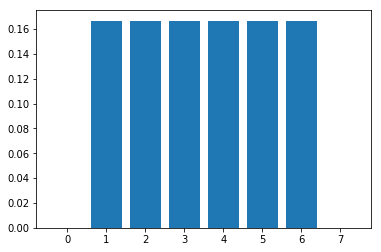

In [53]:
gs = systot_H(T).groundstate()[1]
gs_amps = np.array([abs(gs[i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], gs_amps.flatten())
plt.show()

### Now Let's do a Numerical Anneal on the Entire System

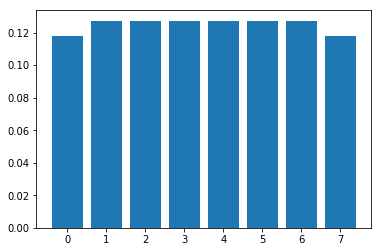

In [24]:
results = qt.sesolve(systot_listH, systot_H(0).groundstate()[1], systot_times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()

## Forward Anneal System A and Reverse Anneal System B
### First Up, Exact Diagalization

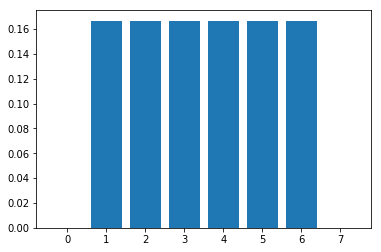

In [54]:
gs = sysAB_H(T).groundstate()[1]
gs_amps = np.array([abs(gs[i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], gs_amps.flatten())
plt.show()

### Now for the Numerical Anneal of A and B in tandem
Here, the initial state is slightly more complicated than the ground-state of H(0) (the equal superposition state). Instead, sysA starts out in the initial superposition state whereas sysB starts out in some user-defined classical state. For this example, we'll just choose up-up for this. 

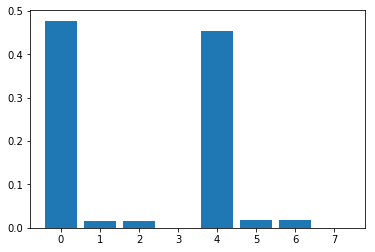

In [83]:
# q0 is the only qubit in system A in this example
q0init_state = (qts.ket([0]) + qts.ket([1])).unit()
# q1 and q2 are part of system B in this example
q1init_state = qts.ket([0])
q2init_state = qts.ket([0])

# to combine the system state together, we need only take the tensor product
init_state = qt.tensor(q0init_state, q1init_state, q2init_state)

# the actual numerical simulation
results = qt.sesolve(sysAB_listH, init_state, systot_times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()